# MNIST Digit Recognition Using a Convolutional Network

Based on PyTorch example at https://github.com/pytorch/examples/blob/master/mnist/main.py

![](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

<small>(https://commons.wikimedia.org/wiki/File:MnistExamples.png)</small>

In [1]:
import torch
import torchvision
import numpy as np
import random, datetime
import matplotlib.pyplot as plt

In [2]:
batch_size = 64
download_loc = '/tmp/'

# The global mean and std deviation for the MNIST dataset
# We'll use these to normalize the data
mnist_mean = 0.1307
mnist_std = 0.3081
transformation = \
    torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((mnist_mean,), (mnist_std,))])

# Load MNIST training and testing datasets
train = torch.utils.data.DataLoader(torchvision.datasets.MNIST(download_loc, train=True, download=True, transform=transformation), batch_size=batch_size, shuffle=True)
test = torch.utils.data.DataLoader(torchvision.datasets.MNIST(download_loc, train=False, download=True, transform=transformation), batch_size=batch_size, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 11383632.18it/s]


Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 1069781.99it/s]


Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 9505426.12it/s]


Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|███████████████████████████████████| 4542/4542 [00:00<00:00, 887102.62it/s]

Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw



The samples are greyscale $28 \times 28$ images.  With the one greyscale channel, each image is a $1 \times 28 \times 28$ tensor.

9
torch.Size([1, 28, 28])


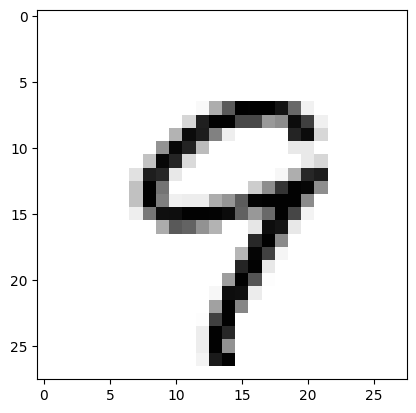

In [3]:
samples, digits = next(iter(train))
plt.imshow(1 - torch.squeeze(samples[0]), cmap='gray')
print(digits[0].item())
print(samples[0].shape)

We'll define the neural network and some helper modules here.

In [4]:
# A few helper modules
debug = True

# If the debug global is enabled, this will print the shape of any input given
class ShapeDebugger(torch.nn.Module):
    def __init__(self, label):
        super(ShapeDebugger, self).__init__()
        self.label = label
        
    def forward(self, x):
        global debug
        if debug:
            print(f'{self.label} ({x.shape})')
        return x

# Reshapes input to a given size
class Reshaper(torch.nn.Module):
    def __init__(self, shape):
        super(Reshaper, self).__init__()
        self.shape = shape
    
    def forward(self, x):
        return x.reshape(self.shape)

# The convolutional network itself
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layers = torch.nn.Sequential(
            ShapeDebugger('Input\t\t\t'),
            torch.nn.Conv2d(1,  10, kernel_size=5), 
            torch.nn.MaxPool2d(2), 
            torch.nn.ReLU(), 
            ShapeDebugger('1st Conv\t\t'),
            torch.nn.Conv2d(10, 20, kernel_size=5), 
            torch.nn.Dropout2d(), 
            torch.nn.MaxPool2d(2), 
            torch.nn.ReLU(), 
            ShapeDebugger('2nd Conv\t\t'),
            Reshaper((-1, 320)),
            ShapeDebugger('Flattening\t\t'),
            torch.nn.Linear(320, 100),
            torch.nn.ReLU(),
            ShapeDebugger('1st fully-connected\t'),
            torch.nn.Dropout(),
            torch.nn.Linear(100, 10),
            torch.nn.LogSoftmax(dim=1),
            ShapeDebugger('2nd fully-connected\t'),
        )

    def forward(self, samples):
        # Forward propagation
        return self.layers(samples)

We can see how the shapes change through the forward propagation process

In [5]:
cnn = CNN()
debug = True
cnn.forward(samples)
debug = False

Input			 (torch.Size([64, 1, 28, 28]))
1st Conv		 (torch.Size([64, 10, 12, 12]))
2nd Conv		 (torch.Size([64, 20, 4, 4]))
Flattening		 (torch.Size([64, 320]))
1st fully-connected	 (torch.Size([64, 100]))
2nd fully-connected	 (torch.Size([64, 10]))


In [6]:
opt = torch.optim.Adam(cnn.parameters(), lr=0.01)
train_loss = []
test_loss = []
loss_fn = torch.nn.NLLLoss()

In [7]:
def eval_ds(ds):
    full_loss = 0
    for samples, values in ds:
        with torch.no_grad(): # we don't need the gradient here! this speeds up execution
            predicted = cnn(samples)
            loss = loss_fn(predicted, values)
            full_loss += loss.item()
    return full_loss / len(ds)

In [8]:
num_epochs = 2

train_loss.append(eval_ds(train))
test_loss.append(eval_ds(test))
print('epoch',0,train_loss[0])

for i in range(num_epochs):
    for samples, values in train:
        opt.zero_grad()
        predicted = cnn(samples)
        loss = loss_fn(predicted, values)
        loss.backward()
        opt.step()
    
    train_loss.append(eval_ds(train))
    test_loss.append(eval_ds(test))
    print('epoch',i+1,train_loss[-1])

epoch 0 2.3297322912256857
epoch 1 0.40317956819685535
epoch 2 0.43639473902232356


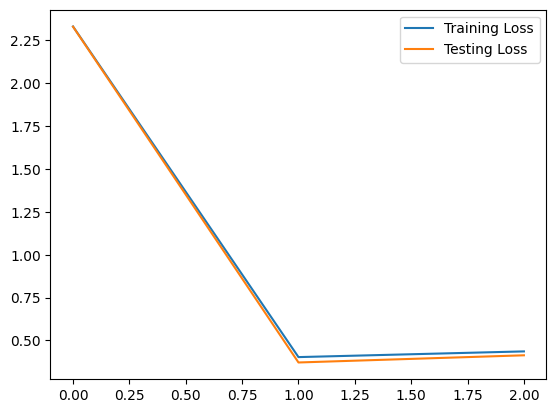

In [12]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()

In [13]:
def predict(image):
    with torch.no_grad():
        out = cnn(image.unsqueeze(0).unsqueeze(0)).numpy()
        return np.argmax(out)

Prediction 7 True 9


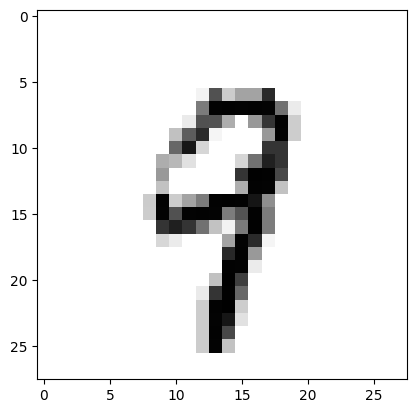

In [28]:
samples, digits = next(iter(train))
img = torch.squeeze(samples[0])
plt.imshow(1 - img, cmap='gray')
print('Prediction', predict(img), 'True', digits[0].item())